In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) 

In [2]:
dataset3 = tf.keras.preprocessing.image_dataset_from_directory(directory='C:/brain_tumor/version2/classify_dataset/meningioma', label_mode=None, batch_size=8, image_size=(256, 256), shuffle=True, color_mode='grayscale')
dataset3 = dataset3.map(lambda x: (x - 127.5) / 127.5)
dataset3 = dataset3.cache()
dataset3 = dataset3.prefetch(16)

Found 1487 files belonging to 1 classes.


In [3]:
dataset3.as_numpy_iterator().next().shape

(8, 256, 256, 1)

In [4]:
from tensorflow import keras
from keras.layers import BatchNormalization, Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, Conv2DTranspose
from keras.models import Sequential

def dc_generator():

    model = Sequential()

    model.add(Dense(16*16*256, input_dim=256))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 256)))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same', use_bias=False))
    # model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2DTranspose(1, (4,4), strides=(2,2), padding='same',use_bias=False, activation='tanh'))
    
    return model

In [5]:
dc_generator = dc_generator()
dc_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 65536)             16842752  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 65536)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      524288    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 64)       131072    
 ranspose)                                              

In [6]:
image_dc = dc_generator.predict(np.random.randn(4, 256))
image_dc.shape

1/1 [==============================] - 3s 3s/step


(4, 256, 256, 1)

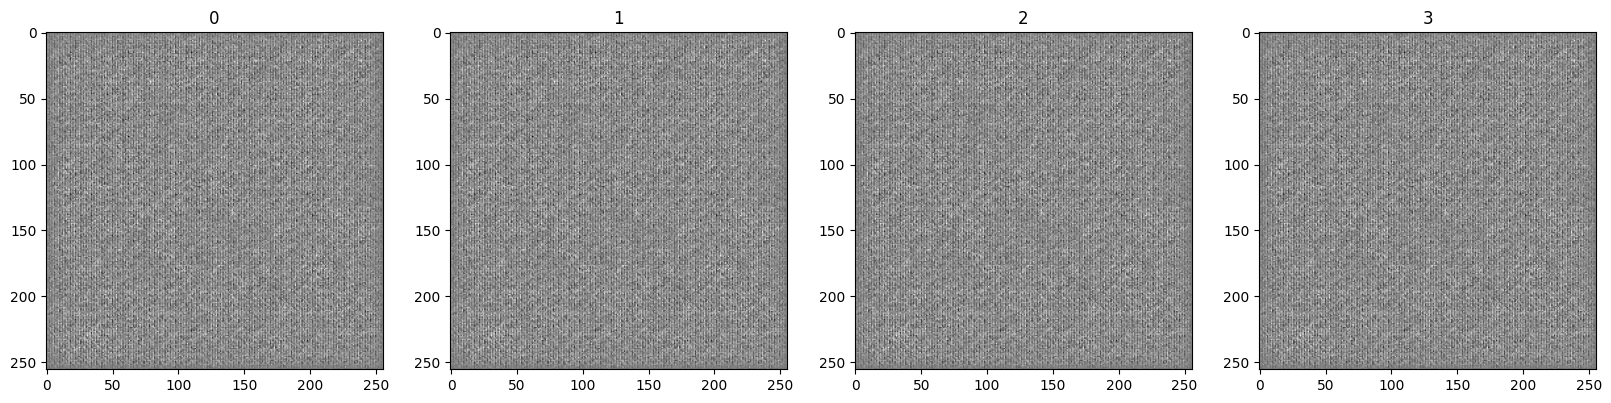

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(image_dc):
    for i in range(4):
        ax[idx].imshow(np.squeeze(image_dc[i]), cmap='gray')
        ax[idx].title.set_text(idx)

In [8]:
#discriminator
def dc_discriminator(input=(256,256,1)):

    model = Sequential()
    
    model.add(Conv2D(32, (4,4), strides=(2, 2), padding='same',input_shape=input))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, (4,4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, (4,4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, (4,4), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [9]:
dc_discriminator = dc_discriminator()
dc_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      544       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                      

In [10]:
dc_discriminator.predict(image_dc)

1/1 [==============================] - 0s 130ms/step


array([[0.5000349 ],
       [0.49999028],
       [0.49998724],
       [0.499987  ]], dtype=float32)

In [4]:
from tensorflow import keras
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Model
from keras.callbacks import Callback
import os

dc_d_optimizer=Adam(lr=0.00003)
dc_g_optimizer=Adam(lr=0.0003)
d_loss=BinaryCrossentropy()
g_loss=BinaryCrossentropy()

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
class DCGAN(Model):
    def __init__(self, dc_generator, dc_discriminator):
        super().__init__()
        self.dc_generator = dc_generator
        self.dc_discriminator = dc_discriminator
    #     self.g_loss_metric = keras.metrics.Mean(name='g_loss')
    #     self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    # @property
    # def metrics(self):
    #     return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, dc_g_optimizer, dc_d_optimizer, d_loss, g_loss):
        super(DCGAN, self).compile()
        self.dc_g_optimizer = dc_g_optimizer
        self.dc_d_optimizer = dc_d_optimizer
        self.d_loss = d_loss
        self.g_loss = g_loss
        # self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, 256))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.dc_discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels -= 0.15 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.d_loss(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.dc_generator(random_noise)
            pred_fake = self.dc_discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            fake_labels += 0.15 * tf.random.uniform(tf.shape(fake_labels))
            d_loss_fake = self.d_loss(fake_labels, pred_fake)
            
            # total discriminator loss
            dc_d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(dc_d_loss, self.dc_discriminator.trainable_variables)
        # update the gradients
        self.dc_d_optimizer.apply_gradients(zip(gradients, self.dc_discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.dc_generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.dc_discriminator(fake_images, training=True)
            # compute loss
            dc_g_loss = self.g_loss(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(dc_g_loss, self.dc_generator.trainable_variables)
        # update the gradients
        self.dc_g_optimizer.apply_gradients(zip(gradients, self.dc_generator.trainable_variables))
        
        # # update states for both models
        # self.d_loss_metric.update_state(dc_d_loss)
        # self.g_loss_metric.update_state(dc_g_loss)
        
        return {'d_loss': dc_d_loss, 'g_loss': dc_g_loss}

In [6]:
class DCGANMonitor(Callback):
    def __init__(self, num_imgs=3, latent_dim=256):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        # self.noise = tf.random.normal([4, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        noise = tf.random.normal([self.num_imgs, self.latent_dim])
        g_img = self.model.dc_generator(noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
        fig = plt.figure(figsize=(20, 20))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = tf.keras.utils.array_to_img(g_img[i])
            # img.save(os.path.join('output_dcgan2', f'generated_img_from150_{epoch}_{i}.png'))
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

In [14]:
brain_tumor_dc = DCGAN(dc_generator, dc_discriminator)
brain_tumor_dc.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)

In [ ]:
N_EPOCHS = 50
brain_tumor_dc.fit(dataset3, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

In [16]:
dc_discriminator.save('meni_model/dis1(50e).h5')
dc_generator.save('meni_model/gen1(50e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator1 = load_model('meni_model/gen1(50e).h5')
load_dc_discriminator1 = load_model('meni_model/dis1(50e).h5')
dc_model1 = DCGAN(load_dc_generator1, load_dc_discriminator1)
dc_model1.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist1 = dc_model1.fit(dataset3, epochs=100, callbacks=[DCGANMonitor()])

In [18]:
load_dc_discriminator1.save('meni_model/dis2(150e).h5')
load_dc_generator1.save('meni_model/gen2(150e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator2 = load_model('meni_model/gen2(150e).h5')
load_dc_discriminator2 = load_model('meni_model/dis2(150e).h5')
dc_model2 = DCGAN(load_dc_generator2, load_dc_discriminator2)
dc_model2.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist2 = dc_model2.fit(dataset3, epochs=150, callbacks=[DCGANMonitor()])

In [8]:
load_dc_discriminator2.save('meni_model/dis3(300e).h5')
load_dc_generator2.save('meni_model/gen3(300e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator3 = load_model('meni_model/gen3(300e).h5')
load_dc_discriminator3 = load_model('meni_model/dis3(300e).h5')
dc_model3 = DCGAN(load_dc_generator3, load_dc_discriminator3)
dc_model3.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist3 = dc_model3.fit(dataset3, epochs=200, callbacks=[DCGANMonitor()])

In [8]:
load_dc_discriminator3.save('meni_model/dis4(500e).h5')
load_dc_generator3.save('meni_model/gen4(500e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator4 = load_model('meni_model/gen4(500e).h5')
load_dc_discriminator4 = load_model('meni_model/dis4(500e).h5')
dc_model4 = DCGAN(load_dc_generator4, load_dc_discriminator4)
dc_model4.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist4 = dc_model4.fit(dataset3, epochs=200, callbacks=[DCGANMonitor()])

In [8]:
load_dc_discriminator4.save('meni_model/dis5(700e).h5')
load_dc_generator4.save('meni_model/gen5(700e).h5')

In [ ]:
from keras.models import load_model
load_dc_generator5 = load_model('meni_model/gen5(700e).h5')
load_dc_discriminator5 = load_model('meni_model/dis5(700e).h5')
dc_model5 = DCGAN(load_dc_generator5, load_dc_discriminator5)
dc_model5.compile(dc_g_optimizer, dc_d_optimizer, d_loss, g_loss)
hist5 = dc_model5.fit(dataset3, epochs=200, callbacks=[DCGANMonitor()])

In [8]:
load_dc_discriminator5.save('meni_model/dis6(900e).h5')
load_dc_generator5.save('meni_model/gen6(900e).h5')